Data loading, preprocessing and preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader

# load brain_extraction data
X_Guys = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/X_Guys.npy')
y_Guys = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/y_Guys.npy')
ids_Guys = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/ids_Guys.npy')
X_HH = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/X_HH.npy')
y_HH = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/y_HH.npy')
ids_HH = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/ids_HH.npy')
X_IOP = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/X_IOP.npy')
y_IOP = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/y_IOP.npy')
ids_IOP = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/ids_IOP.npy')

#center data
def centring(X):
    X=np.asarray(X)
    epsilon = 1e-7 
    mean = np.mean(X, axis=0, keepdims=True)
    std = np.std(X, axis=0, keepdims=True)
    centered_array = (X - mean) / (std+epsilon)
    return centered_array

def to_one_hot_binary_matrix_batch(batch_matrix):
    batch_matrix = np.array(batch_matrix, dtype='int')
    one_hot = np.zeros((batch_matrix.shape[0], 2, batch_matrix.shape[1], batch_matrix.shape[2]), dtype=float)
    one_hot[:, 0] = batch_matrix == 1
    one_hot[:, 1] = batch_matrix == 0
    return one_hot


X_Guys_centered=centring(X_Guys)
X_HH_centered=centring(X_HH)
X_IOP_centered=centring(X_IOP)

# producing required train / val / test split
print("initial shapes")
print(X_Guys.shape)
print(y_Guys.shape)
print(ids_Guys.shape)
print(X_HH.shape)
print(y_HH.shape)
print(ids_HH.shape)
print(X_IOP.shape)
print(y_IOP.shape)
print(ids_IOP.shape)

combined_Guys_HH_X = np.concatenate([X_Guys_centered, X_HH_centered], axis=0)
combined_Guys_HH_y = np.concatenate([y_Guys, y_HH], axis=0)

X_train = torch.Tensor(combined_Guys_HH_X[0:int(len(combined_Guys_HH_X)*0.85)])
y_train = torch.Tensor(combined_Guys_HH_y[0:int(len(combined_Guys_HH_y)*0.85)])

# val data 15%
X_val = torch.Tensor(combined_Guys_HH_X[int(len(combined_Guys_HH_X)*0.85):int(len(combined_Guys_HH_X))])
y_val = torch.Tensor(combined_Guys_HH_y[int(len(combined_Guys_HH_y)*0.85):int(len(combined_Guys_HH_y))])
#test data from IOP data
X_test =  torch.Tensor(X_IOP_centered[0:int(len(X_IOP_centered))])
y_test = torch.Tensor(y_IOP[0:int(len(y_IOP))])

print("Check after split")
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)
# slice data into 2D
def reslice(x, split_size):
  temp = torch.split(x,split_size,dim=1)
  output=[]
  for i in range(len(temp)):
    output.append(temp[i])
  output=torch.cat(output, dim=0)
  return output

#X_train=reslice(X_train,1)
#y_train=reslice(y_train,1)
#X_val=reslice(X_val,1)
#y_val=reslice(y_val,1)
#X_test=reslice(X_test,1)
#y_test=reslice(y_test,1)


X_train=X_train[:,10,:,:]
X_val=X_val[:,20,:,:]
X_test=X_test[:,30,:,:]
y_train=y_train[:,10,:,:]
y_val=y_val[:,20,:,:]
y_test=y_test[:,30,:,:]

#introduce channel
X_train=torch.reshape(X_train,(len(X_train),1,128,128))
X_val=torch.reshape(X_val,(len(X_val),1,128,128))
X_test=torch.reshape(X_test,(len(X_test),1,128,128))
y_train = to_one_hot_binary_matrix_batch(y_train)
y_val= to_one_hot_binary_matrix_batch(y_val)
y_test = to_one_hot_binary_matrix_batch(y_test)


print("Check shapes after slicing into 2D")
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

X_train=np.asarray(X_train)
X_val=np.asarray(X_val)
X_test=np.asarray(X_test)

class numpy_dataset(Dataset): 
    def __init__(self, data, target): 
        self.data =  torch.from_numpy(data)
        self.target = torch.from_numpy(target)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y

    def __len__(self):
        return len(self.data)
    
train_dataset = numpy_dataset(X_train, y_train)
val_dataset = numpy_dataset(X_val, y_val)
test_dataset = numpy_dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

**Load models**

In [ ]:
class SegNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SegNet, self).__init__()

        self.in_channels = in_channels
        self.num_classes = num_classes


        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        self.conv9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn9 = nn.BatchNorm2d(64)
        self.conv10 = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x, pool1_indices = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x, pool2_indices = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x, pool3_indices = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x, pool4_indices = self.pool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x, pool5_indices = self.pool(x)
        x = self.unpool(x, pool5_indices)
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.unpool(x, pool4_indices)
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.unpool(x, pool3_indices)
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.unpool(x, pool2_indices)
        x = F.relu(self.bn9(self.conv9(x)))
        x = self.conv10(x)
        x = F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)
        return torch.sigmoid(x)


class FCN_flexible(nn.Module):
    def __init__(self, input_shape=(1, 128, 128), num_classes=2, dropout_prob=0.5, num_layers=2):
        super(FCN_flexible, self).__init__()
        encoder_layers = []
        in_channels = input_shape[0]
        for i in range(num_layers):
            out_channels = 64 * (2 ** i)
            encoder_layers.extend([
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_prob),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            in_channels = out_channels

        self.encoder = nn.Sequential(*encoder_layers)
        self.middle = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob),
            nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        )
        decoder_layers = []
        for i in range(num_layers - 1, -1, -1):
            out_channels = 64 * (2 ** i)
            decoder_layers.extend([
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_prob)
            ])
            in_channels = out_channels

        decoder_layers.extend([
            nn.Conv2d(out_channels, num_classes, kernel_size=1),
            nn.Sigmoid()
        ])

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x


def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = conv_block(in_channels, out_channels)

    def forward(self, x):
        return self.conv(self.pool(x))

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = conv_block(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat((skip, x), dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.init_conv = conv_block(in_channels, 64)
        self.encoders = nn.ModuleList([
            Encoder(64, 128),
            Encoder(128, 256),
            Encoder(256, 512),
            Encoder(512, 1024)
        ])
        self.decoders = nn.ModuleList([
            Decoder(1024, 512),
            Decoder(512, 256),
            Decoder(256, 128),
            Decoder(128, 64)
        ])
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.init_conv(x)
        skips = [x1]
        for encoder in self.encoders:
            skips.append(encoder(skips[-1]))

        x = skips.pop()
        for decoder in self.decoders:
            x = decoder(x, skips.pop())

        return self.final_conv(x)


# dice metric and training loops adapted from Kaggle
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

def predict(net, test_dataloader):
    test_dice=0

    with torch.no_grad(): 
        for batch_idx, (data, target) in enumerate(test_dataloader):
          data = data.to(device).float()
          target = target.to(device).float()
           
          pred = net(data)
    return data.data.cpu().numpy(),target.data.cpu().numpy(),pred.data.cpu().numpy()

def prediction_dice(net, test_dataloader):
    test_dice=0

    with torch.no_grad():  
        for batch_idx, (data, target) in enumerate(test_dataloader):
          data = data.to(device).float()
          target = target.to(device).float()
           
          pred = net(data)
          out_cut = np.copy(pred.data.cpu().numpy())
          out_cut[np.nonzero(out_cut < 0.5)] = 0.0
          out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
          dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
          test_dice += dice
        mean_dice = test_dice / len(test_dataloader)
        return mean_dice


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#unet
unet = UNet(n_channels=1, n_classes=2).to(device)
unet.load_state_dict(torch.load("/content/drive/MyDrive/dhl_exam/models/unet_model_brain.pth"))
unet.eval()

#segnet
segnet = SegNet(in_channels=1, num_classes=2).to(device)
segnet.load_state_dict(torch.load("/content/drive/MyDrive/dhl_exam/models/segnet_model_brain.pth"))
segnet.eval()

#FCN 6
fcn6= FCN_flexible(input_shape=(1, 128, 128), num_classes=2, dropout_prob=0.5, num_layers=6).to(device)
fcn6.load_state_dict(torch.load("/content/drive/MyDrive/dhl_exam/models/fcn6_model_brain.pth"))
fcn6.eval()

#FCN 5
#fcn5= FCN_flexible(input_shape=(1, 128, 128), num_classes=2, dropout_prob=0.5, num_layers=5).to(device)
#fcn5.load_state_dict(torch.load("/content/drive/MyDrive/dhl_exam/models/fcn5_model_brain.pth"))
#fcn5.eval()

#FCN 4
#fcn4= FCN_flexible(input_shape=(1, 128, 128), num_classes=2, dropout_prob=0.5, num_layers=4).to(device)
#fcn4.load_state_dict(torch.load("/content/drive/MyDrive/dhl_exam/models/fcn4_model_brain.pth"))
#fcn4.eval()

FCN_flexible(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Dropout(p=0.5, inplace=False)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Dropout(p=0.5, inplace=False)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 1024, kernel_size=(3, 3),

In [ ]:
# load different models trained on augmented data

VHflip = UNet(n_channels=1, n_classes=2).to(device)
VHflip.load_state_dict(torch.load("/content/drive/MyDrive/dhl_exam/models_data_aug/VHflip_best.pth"))
VHflip.eval()

vertical = UNet(n_channels=1, n_classes=2).to(device)
vertical.load_state_dict(torch.load("/content/drive/MyDrive/dhl_exam/models_data_aug/vertical_best.pth"))
vertical.eval()

horizontal = UNet(n_channels=1, n_classes=2).to(device)
horizontal.load_state_dict(torch.load("/content/drive/MyDrive/dhl_exam/models_data_aug/horizontal.pth"))
horizontal.eval()

rot = UNet(n_channels=1, n_classes=2).to(device)
rot.load_state_dict(torch.load("/content/drive/MyDrive/dhl_exam/models_data_aug/rot_best.pth"))
rot.eval()

histogram = UNet(n_channels=1, n_classes=2).to(device)
histogram.load_state_dict(torch.load("/content/drive/MyDrive/dhl_exam/models_data_aug/histogram_best.pth"))
histogram.eval()

contrast = UNet(n_channels=1, n_classes=2).to(device)
contrast.load_state_dict(torch.load("/content/drive/MyDrive/dhl_exam/models_data_aug/contrast_best.pth"))
contrast.eval()

blur = UNet(n_channels=1, n_classes=2).to(device)
blur.load_state_dict(torch.load("/content/drive/MyDrive/dhl_exam/models_data_aug/blur_best.pth"))
blur.eval()

base = UNet(n_channels=1, n_classes=2).to(device)
base.load_state_dict(torch.load("/content/drive/MyDrive/dhl_exam/models_data_aug/base_best.pth"))
base.eval()

base_20 = UNet(n_channels=1, n_classes=2).to(device)
base_20.load_state_dict(torch.load("/content/drive/MyDrive/dhl_exam/models_data_aug/base_20_slices.pth"))
base_20.eval()

In [ ]:
print(prediction_dice(unet,train_dataloader))
print(prediction_dice(segnet,train_dataloader))
print(prediction_dice(fcn6,train_dataloader))




0.9873634712716327
0.9945451808791278
0.9451834409340262


Visualise data

UNET

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


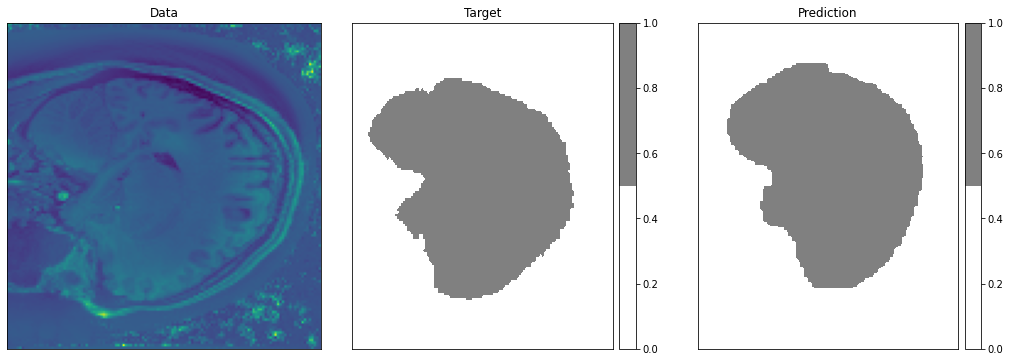

In [ ]:
from matplotlib.colors import ListedColormap
data,target,prediction=predict(fcn6,test_dataloader)
idx = 4
custom_cmap = ListedColormap(['white', 'grey'])
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
im1 = axes[0].imshow(data[idx][0], aspect='auto')
axes[0].set_title('Data')
im2 = axes[1].imshow(target[idx][0], cmap=custom_cmap, aspect='auto')
axes[1].set_title('Target')
fig.colorbar(im2, ax=axes[1], pad=0.02)
im3 = axes[2].imshow(prediction[idx][0], cmap=custom_cmap, aspect='auto')
axes[2].set_title('Prediction')
fig.colorbar(im3, ax=axes[2], pad=0.02)
plt.subplots_adjust(wspace=0.1)
plt.show()




SEGNET

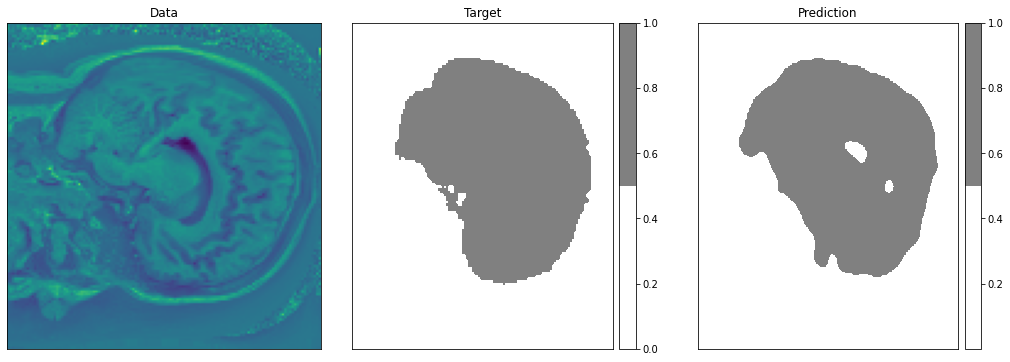

In [ ]:
data,target,prediction=predict(segnet,test_dataloader)
idx = 4
custom_cmap = ListedColormap(['white', 'grey'])

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

im1 = axes[0].imshow(data[idx][0], aspect='auto')
axes[0].set_title('Data')

im2 = axes[1].imshow(target[idx][0], cmap=custom_cmap, aspect='auto')
axes[1].set_title('Target')
fig.colorbar(im2, ax=axes[1], pad=0.02)

im3 = axes[2].imshow(prediction[idx][0], cmap=custom_cmap, aspect='auto')
axes[2].set_title('Prediction')
fig.colorbar(im3, ax=axes[2], pad=0.02)

plt.subplots_adjust(wspace=0.1)

plt.show()



FCN

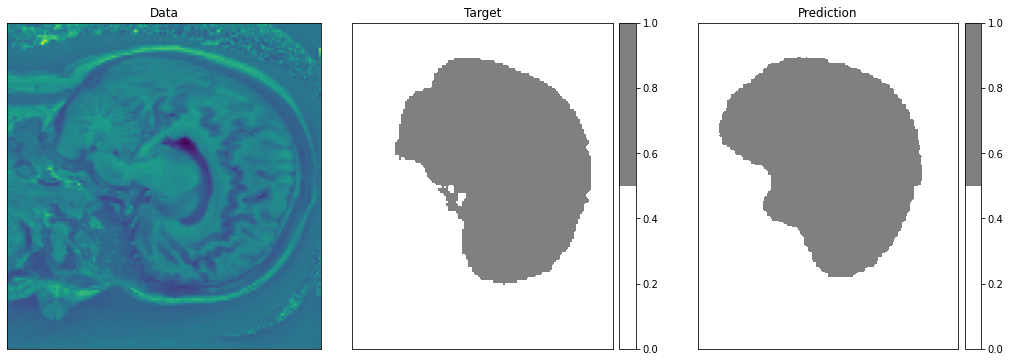

In [ ]:
data,target,prediction=predict(fcn6,test_dataloader)
idx = 4
custom_cmap = ListedColormap(['white', 'grey'])

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
im1 = axes[0].imshow(data[idx][0], aspect='auto')
axes[0].set_title('Data')
im2 = axes[1].imshow(target[idx][0], cmap=custom_cmap, aspect='auto')
axes[1].set_title('Target')
fig.colorbar(im2, ax=axes[1], pad=0.02)
im3 = axes[2].imshow(prediction[idx][0], cmap=custom_cmap, aspect='auto')
axes[2].set_title('Prediction')
fig.colorbar(im3, ax=axes[2], pad=0.02)
plt.subplots_adjust(wspace=0.1)
plt.show()

In [ ]:
print(prediction_dice(unet,test_dataloader))
print(prediction_dice(segnet,test_dataloader))
print(prediction_dice(fcn6,test_dataloader))

0.9388115760814904
0.9335964677474746
0.8981380612105564


Compute volumentric data from 2D

In [ ]:
import torch

def sum_pixels_per_class(one_hot_tensor):
    one_hot_tensor=torch.from_numpy(one_hot_tensor)
    assert one_hot_tensor.shape == (2, 128, 128), "The input tensor shape should be (2, 128, 128)"
    pixel_sums = torch.sum(one_hot_tensor, dim=(1, 2))
    return pixel_sums

def sum_pixels_per_class_batch(one_hot_batch_tensor):
    assert one_hot_batch_tensor.shape == (40, 2, 128, 128), "The input tensor shape should be (40, 2, 128, 128)"
    pixel_sums = torch.sum(one_hot_batch_tensor, dim=(0, 2, 3))
    return pixel_sums



In [ ]:
X_test =  torch.Tensor(X_IOP_centered[0:int(len(X_IOP_centered))])
y_test = torch.Tensor(y_IOP[0:int(len(y_IOP))])
X_test_slices = np.asarray(reslice(X_test,1))
y_test_slices = reslice(y_test,1).reshape((2840, 128, 128))
y_test_slices = to_one_hot_binary_matrix_batch(y_test_slices)
print(X_test_slices.shape)
print(y_test_slices.shape)

def calculate_vol(net, test_dataloader):
    dict_1_preds={}
    dict_0_preds={}
    dict_1_true={}
    dict_0_true={}
 
    class_1_volume_pred=0
    class_0_volume_pred=0
    class_1_volume_true=0
    class_0_volume_true=0


    with torch.no_grad():  
        for batch_idx, (data, target) in enumerate(test_dataloader):
          data = data.to(device).float()
          target = target.to(device).float()
          pred = net(data)
          class_1_volume_pred+=sum_pixels_per_class_batch(pred)[0]
          class_0_volume_pred+=sum_pixels_per_class_batch(pred)[1]
          class_1_volume_true+=sum_pixels_per_class_batch(target)[0]
          class_0_volume_true+=sum_pixels_per_class_batch(target)[1]
          dict_1_preds[batch_idx]=sum_pixels_per_class_batch(pred)[0].cpu().numpy()
          dict_0_preds[batch_idx]=sum_pixels_per_class_batch(pred)[1].cpu().numpy()
          dict_1_true[batch_idx]=sum_pixels_per_class_batch(target)[0].cpu().numpy()
          dict_0_true[batch_idx]=sum_pixels_per_class_batch(target)[1].cpu().numpy()

    return class_1_volume_pred.cpu().numpy(),class_0_volume_pred.cpu().numpy(),class_1_volume_true.cpu().numpy(), class_0_volume_true.cpu().numpy(),class_2_volume_pred.cpu().numpy(),class_3_volume_pred.cpu().numpy(),class_2_volume_true.cpu().numpy(), class_3_volume_true.cpu().numpy()

test_dataset = numpy_dataset(X_test_slices, y_test_slices)
test_dataloader = DataLoader(test_dataset, batch_size=40, shuffle=False, drop_last=False)

In [ ]:
# unet
class_1_volume_pred,class_0_volume_pred,class_1_volume_true, class_0_volume_true, dict_1_preds, dict_1_preds, dict_0_preds,dict_1_true,dict_0_true = calculate_vol(fcn6,test_dataloader)
print("Brain volume")
print(class_1_volume_pred)
print(class_1_volume_true)
print("Other area volume")
print(class_0_volume_pred)
print(class_0_volume_true)
class_1_volume_true-class_1_volume_pred

errors=[]
for k in dict_1_preds.keys():
  true_volume=dict_1_true[k]
  predicted_volume=dict_1_preds[k]
  delta=np.abs(true_volume-predicted_volume)
  error = delta/true_volume
  errors.append(error)


print("Average error on test data")
print(np.mean(errors))
print("Average std on test data")
print(np.std(errors))

In [ ]:
# unet
class_1_volume_pred,class_0_volume_pred,class_1_volume_true, class_0_volume_true, dict_1_preds, dict_1_preds, dict_0_preds,dict_1_true,dict_0_true = calculate_vol(segnet,test_dataloader)
print("Brain volume")
print(class_1_volume_pred)
print(class_1_volume_true)
print("Other area volume")
print(class_0_volume_pred)
print(class_0_volume_true)
class_1_volume_true-class_1_volume_pred

errors=[]
for k in dict_1_preds.keys():
  true_volume=dict_1_true[k]
  predicted_volume=dict_1_preds[k]
  delta=np.abs(true_volume-predicted_volume)
  error = delta/true_volume
  errors.append(error)


print("Average error on test data")
print(np.mean(errors))
print("Average std on test data")
print(np.std(errors))

In [ ]:
# segnet
class_1_volume_pred,class_0_volume_pred,class_1_volume_true, class_0_volume_true, dict_1_preds, dict_1_preds, dict_0_preds,dict_1_true,dict_0_true = calculate_vol(fcn6,test_dataloader)
print("Brain volume")
print(class_1_volume_pred)
print(class_1_volume_true)
print("Other area volume")
print(class_0_volume_pred)
print(class_0_volume_true)
class_1_volume_true-class_1_volume_pred

errors=[]
for k in dict_1_preds.keys():
  true_volume=dict_1_true[k]
  predicted_volume=dict_1_preds[k]
  delta=np.abs(true_volume-predicted_volume)
  error = delta/true_volume
  errors.append(error)


print("Average error on test data")
print(np.mean(errors))
print("Average std on test data")
print(np.std(errors))

In [ ]:
# fcn6
class_1_volume_pred,class_0_volume_pred,class_1_volume_true, class_0_volume_true, dict_1_preds, dict_1_preds, dict_0_preds,dict_1_true,dict_0_true = calculate_vol(fcn6,test_dataloader)
print("Brain volume")
print(class_1_volume_pred)
print(class_1_volume_true)
print("Other area volume")
print(class_0_volume_pred)
print(class_0_volume_true)
class_1_volume_true-class_1_volume_pred

errors=[]
for k in dict_1_preds.keys():
  true_volume=dict_1_true[k]
  predicted_volume=dict_1_preds[k]
  delta=np.abs(true_volume-predicted_volume)
  error = delta/true_volume
  errors.append(error)


print("Average error on test data")
print(np.mean(errors))
print("Average std on test data")
print(np.std(errors))

In [ ]:
# fcn5
class_1_volume_pred,class_0_volume_pred,class_1_volume_true, class_0_volume_true, dict_1_preds, dict_1_preds, dict_0_preds,dict_1_true,dict_0_true = calculate_vol(fcn5,test_dataloader)
print("Brain volume")
print(class_1_volume_pred)
print(class_1_volume_true)
print("Other area volume")
print(class_0_volume_pred)
print(class_0_volume_true)
class_1_volume_true-class_1_volume_pred

errors=[]
for k in dict_1_preds.keys():
  true_volume=dict_1_true[k]
  predicted_volume=dict_1_preds[k]
  delta=np.abs(true_volume-predicted_volume)
  error = delta/true_volume
  errors.append(error)

print("Average error on test data")
print(np.mean(errors))
print("Average std on test data")
print(np.std(errors))

In [ ]:
# fcn4
class_1_volume_pred,class_0_volume_pred,class_1_volume_true, class_0_volume_true, dict_1_preds, dict_1_preds, dict_0_preds,dict_1_true,dict_0_true = calculate_vol(fcn4,test_dataloader)
print("Brain volume")
print(class_1_volume_pred)
print(class_1_volume_true)
print("Other area volume")
print(class_0_volume_pred)
print(class_0_volume_true)
class_1_volume_true-class_1_volume_pred

# calculating statistics 
errors=[]
for k in dict_1_preds.keys():
  true_volume=dict_1_true[k]
  predicted_volume=dict_1_preds[k]
  delta=np.abs(true_volume-predicted_volume)
  error = delta/true_volume
  errors.append(error)

print("Average error on test data")
print(np.mean(errors))
print("Average std on test data")
print(np.std(errors))